# Crawler for 2019-nCoV
## Data: From TenCent

In [1]:
import time
import json
import requests
from datetime import datetime
import numpy as np
import matplotlib
import matplotlib.figure
from matplotlib.font_manager import FontProperties
from matplotlib.backends.backend_agg import FigureCanvasAgg
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
##function: save the rusult json data to json file for view
def save_json(jsondata, filename):
    json_str = json.dumps(jsondata, indent=4,ensure_ascii=False)
    with open(filename, 'w') as f:
        f.write(json_str)
    return

## 1. Catch News Timeline from Website
###      last 20 ones

In [3]:
url_timeline = 'https://view.inews.qq.com/g2/getOnsInfo?name=wuwei_ww_time_line&callback=&_=%d'%int(time.time()*1000)
timeline_data = json.loads(requests.get(url=url_timeline).json()['data'])
timeline_data

[{'time': '2-07 13:17',
  'title': '财政部：新冠肺炎患者个人负担费用中央财政补助60%',
  'desc': '2月7日，财政部副部长余蔚平在新闻发布会上说，截至2月6日，财政部会同有关部门已经出台十余条财税支持措施。明确患者治疗费用，对确诊患者个人负担费用实行财政兜底，中央财政补助60%；对疑似患者，由就医地制定财政补助政策，中央财政视情给予适当补助。',
  'source': '中国新闻网',
  'create_time': '2020-02-07T05:37:16.000Z'},
 {'time': '2-07 13:36',
  'title': '国家监察委员会：派调查组赴武汉就涉李文亮医生的问题作全面调查',
  'desc': '经中央批准，国家监察委员会决定派出调查组赴湖北省武汉市，就群众反映的涉及李文亮医生的有关问题作全面调查。',
  'source': '央视新闻',
  'create_time': '2020-02-07T05:38:07.000Z'},
 {'time': '2-07 12:20',
  'title': '穿山甲是中间宿主？靠谱，而且可能是东南亚的穿山甲',
  'desc': '最新研究表明，穿山甲为新型冠状病毒的潜在中间宿主。对于这一发现，知乎答主、中国科学院遗传学在读博士李雷认为，穿山甲是中间宿主的可能性要大于之前有人猜测的蛇，毕竟穿山甲属于哺乳动物。',
  'source': '腾讯科技&知乎',
  'create_time': '2020-02-07T05:39:46.000Z'},
 {'time': '2-07 19:27',
  'title': '钟南山：疫情拐点还未到来 估计还得有几天',
  'desc': '钟南山：“不能证明拐点到来，但是我的估计这个拐点到来还得有几天。因为最关键的是新增病例，不是出院病例或者死亡病例。出院的话大家标准不一样，但是新增病例是一个重要指标。现在看起来，没有继续的新增病例明显增高，这是个好事。但是这是不是意味着拐点就来了呢？言之过早”',
  'source': '环球时报',
  'create_time': '2020-02-07T11:28:07.000Z'},
 {'time': '2-08 04:07',
  '

### if you are not familiar with JSON, search for more details

In [4]:
save_json(timeline_data, 'timeline.json')

## 2. Catch Data from Website

In [5]:
url ='https://view.inews.qq.com/g2/getOnsInfo?name=disease_h5&callback=&_=%d'%int(time.time()*1000)
data = json.loads(requests.get(url=url).json()['data'])

In [6]:
save_json(data, 'data.json')

### Distr_Data:type dic
### View the 'get.json' file in the repo for json structure detail

## 3. Get Province Distribution

In [7]:
def catch_distribution():
    data = dict()
    url ='https://view.inews.qq.com/g2/getOnsInfo?name=disease_h5&callback=&_=%d'%int(time.time()*1000)
    
    jsondata_dic = json.loads(requests.get(url=url).json()['data'])
    chinalist = jsondata_dic['areaTree'][0]['children'] ##'name' 'today' 'total' 'children'
    for item in chinalist:
        if item["name"] not in data:
            data.update({item['name']:0})
        data[item["name"]] += int(item["total"]["confirm"])

    return data

### Run the following block to view the provibce distribution data

In [8]:
catch_distribution()

{'湖北': 24953,
 '广东': 1095,
 '浙江': 1048,
 '河南': 981,
 '湖南': 803,
 '安徽': 733,
 '江西': 698,
 '江苏': 439,
 '重庆': 428,
 '山东': 416,
 '四川': 363,
 '北京': 315,
 '黑龙江': 295,
 '上海': 286,
 '福建': 239,
 '陕西': 195,
 '河北': 195,
 '广西': 183,
 '云南': 138,
 '海南': 124,
 '山西': 104,
 '辽宁': 103,
 '贵州': 89,
 '天津': 88,
 '甘肃': 71,
 '吉林': 69,
 '内蒙古': 52,
 '宁夏': 45,
 '新疆': 42,
 '香港': 26,
 '青海': 18,
 '台湾': 17,
 '澳门': 10,
 '西藏': 1}

## 4. Get Daily Data

In [9]:
#Input: get: anything but 'dailylist' will return 'addlist'
#Return: date, confirm, suspect, dead, heal

def catch_daily(get = 'dailylist'):
    url ='https://view.inews.qq.com/g2/getOnsInfo?name=disease_h5&callback=&_=%d'%int(time.time()*1000)
    data = json.loads(requests.get(url=url).json()['data'])

    date_list = list() # Date
    confirm_list = list() # Infected
    suspect_list = list() # Suspected
    dead_list = list() # Dead
    heal_list = list() # Heal

    if get == 'dailylist':
        List = data['chinaDayList']
    else:
        List = data['chinaDayAddList']

    for item in List:
        month, day = item['date'].split('.')
        date_list.append(datetime.strptime('2020-%s-%s'%(month, day), '%Y-%m-%d'))
        confirm_list.append(int(item['confirm']))
        suspect_list.append(int(item['suspect']))
        dead_list.append(int(item['dead']))
        heal_list.append(int(item['heal']))

    return date_list, confirm_list, suspect_list, dead_list, heal_list

In [10]:
catch_daily()

([datetime.datetime(2020, 1, 13, 0, 0),
  datetime.datetime(2020, 1, 14, 0, 0),
  datetime.datetime(2020, 1, 15, 0, 0),
  datetime.datetime(2020, 1, 16, 0, 0),
  datetime.datetime(2020, 1, 17, 0, 0),
  datetime.datetime(2020, 1, 18, 0, 0),
  datetime.datetime(2020, 1, 19, 0, 0),
  datetime.datetime(2020, 1, 20, 0, 0),
  datetime.datetime(2020, 1, 21, 0, 0),
  datetime.datetime(2020, 1, 22, 0, 0),
  datetime.datetime(2020, 1, 23, 0, 0),
  datetime.datetime(2020, 1, 24, 0, 0),
  datetime.datetime(2020, 1, 25, 0, 0),
  datetime.datetime(2020, 1, 26, 0, 0),
  datetime.datetime(2020, 1, 27, 0, 0),
  datetime.datetime(2020, 1, 28, 0, 0),
  datetime.datetime(2020, 1, 29, 0, 0),
  datetime.datetime(2020, 1, 30, 0, 0),
  datetime.datetime(2020, 1, 31, 0, 0),
  datetime.datetime(2020, 2, 1, 0, 0),
  datetime.datetime(2020, 2, 2, 0, 0),
  datetime.datetime(2020, 2, 3, 0, 0),
  datetime.datetime(2020, 2, 4, 0, 0),
  datetime.datetime(2020, 2, 5, 0, 0),
  datetime.datetime(2020, 2, 6, 0, 0),
  date

## 5. Data Plot
### Details in 'plot.py'
### Make sure run the following before plot

In [11]:
import plot

### 5.1 Province Distribution
### Make sure you run the block "3. Get Province Distribution" before the following block

In [12]:
data = catch_distribution()
plot.plot_distribution2(data)

### 5.2 Daily Data
### Make sure you run the block "4. Get Daily Data" before the following block

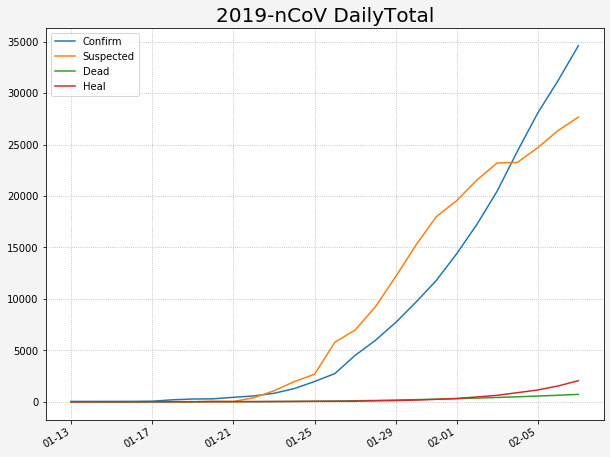

In [13]:
plot.plot_daily(catch_daily())

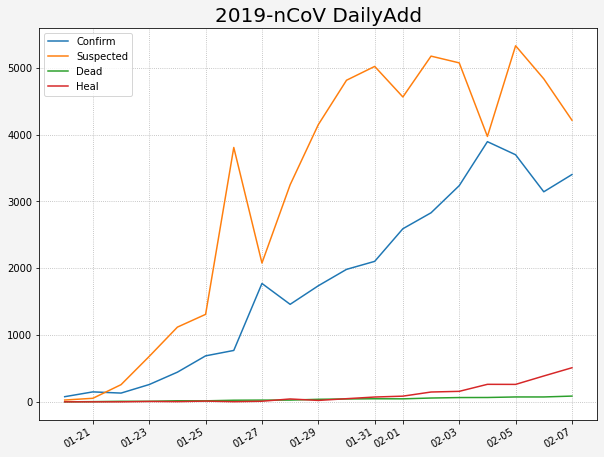

In [14]:
plot.plot_daily(catch_daily('DailyAdd'),'DailyAdd')